In [1]:
import numpy as np
from scipy.linalg import lapack, svd, qr, eig
import QRDM
import time
from auxil import *
import matplotlib.pyplot as plt

In [2]:
help(QRDM)

Help on module QRDM:

NAME
    QRDM - With this wrapper you can run the QRDM algorithm from Python.

FUNCTIONS
    DORMQR(...)
        LAPACK dormqr
    
    QP3(...)
        LAPACK QR with column pivoting (from lapacke)
    
    QRDM(...)
        QR with Deviation Maximization pivoting
    
    QRF(...)
        LAPACK QR without column pivoting (from lapacke)
    
    init(...)
        initialize module

FILE
    /home/jupyter/Jupyter/notebook/qrdm/public/qrdm/QRDM.cpython-38-x86_64-linux-gnu.so




In [3]:
matrix_layout = 102
m = 2**7
n = m
lda = m

In [6]:
#generate matrix with given sv distribution
M = max(m,n)
r = math.floor(min(m,n)*5/10)
# generate random matrix with
# condition number = O(gap)
U,X = qr(np.random.randn(M,M))
V,X = qr(np.random.randn(M,M)) 
gap = 1e-17
sv = np.exp2(1- np.arange(1,M+1)) +gap 
sv[:r] = sv[:r] + 0.01*(r-np.arange(1,r+1));

X = U @ np.diag(sv) @ V.T
print('n=', n)
#controllo il rango numerico
print("cond(X) = ", sv[0]/sv[-1], ", sigma_1 = ", sv[0], "sigma_n = ", sv[-1], "\n")


n= 128
cond(X) =  1.6299999999999997e+17 , sigma_1 =  1.63 sigma_n =  1e-17 



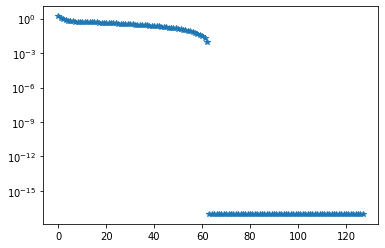

In [7]:
plt.semilogy(sv, '*')

In [8]:
print('Numerical rank = ', r, rank_from_sv(sv, tol=1e-13) )#np.argmin(eigv))

Numerical rank =  64 64


In [9]:
print('Chiamo QP3')
A = X.copy()
jpvt = np.ones((n,),dtype = np.int32)
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QP3(matrix_layout, m,n,A,lda,jpvt,tau)
toc = time.perf_counter()
elQRP = toc-tic
print(f"Elapsed time QP3 {toc - tic:0.10f} seconds")
# controllo fattore Q
Q,R,err,errQ = checkQR(matrix_layout, m, n, A, X, tau, jpvt, verbose = True)

Chiamo QP3
Elapsed time QP3 0.0018759165 seconds
||Q.T*Q - I|| =  1.3827337897599802e-14
||A[:,p] - Q*R|| =  2.584495440391414e-15


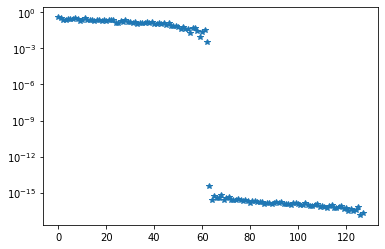

In [10]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')

In [11]:
d = 0.9
t = 0.15
thres = np.array([d,t],dtype = np.float64) #1-0.3

In [12]:
print("\n***************************************\n")
print('QRDM, tau =',t,'delta =',d)
A = X.copy()
jpvt = np.zeros((n,),dtype = np.int32)
ncols = np.zeros((n,),dtype = np.int32) # cambiare zeros in ones o viceversa
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QRDM(matrix_layout, m,n,A,lda,jpvt,tau, ncols,thres,64)
toc = time.perf_counter()
elDMQR = toc-tic
print(f"Elapsed time QRP {toc - tic:0.10f} seconds")
Q,R,err,errQ = checkQR(matrix_layout, m, n, A, X, tau, jpvt, verbose = True)


***************************************

QRDM, tau = 0.15 delta = 0.9
Elapsed time QRP 0.0019971253 seconds
||Q.T*Q - I|| =  1.459831684310286e-14
||A[:,p] - Q*R|| =  3.0441903996365562e-15


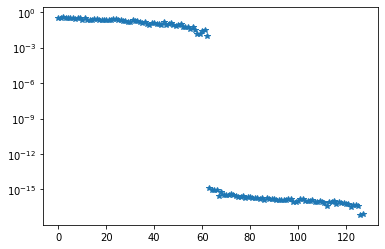

In [13]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')

In [14]:
print("\n***************************************\n")
print('QRDM with stop, tau =',t,'delta =',d)
A = X.copy()
jpvt = np.zeros((n,),dtype = np.int32)
ncols = np.zeros((n,),dtype = np.int32) # cambiare zeros in ones o viceversa
ncols[0] = 1
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QRDM(matrix_layout, m,n,A,lda,jpvt,tau, ncols,thres,64)
toc = time.perf_counter()
elDMQR = toc-tic
print(f"Elapsed time QRP {toc - tic:0.10f} seconds")
r_QRDM = np.sum(ncols[:n])
print('Numerical rank ', r_QRDM)
Q,R,err,errQ = checkQR(matrix_layout, m, n, A, X, tau, jpvt, k = r_QRDM, verbose = True)


***************************************

QRDM with stop, tau = 0.15 delta = 0.9
Elapsed time QRP 0.0017390642 seconds
Numerical rank  78
||Q.T*Q - I|| =  1.0204004159885813e-14
||R_22||_2 =  1.4957005302708597e-15
||A[:,p] - Q*R|| =  3.0496432379080495e-15


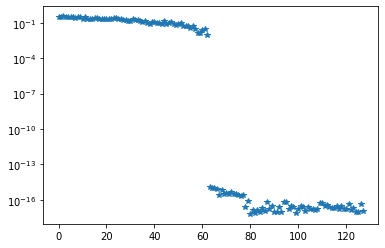

In [15]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')

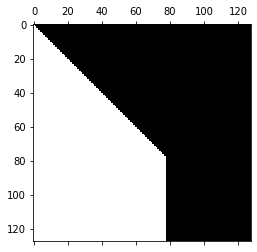

In [16]:
#|R_11 R_12|
#|  0  R_22|
plt.spy(R)